## A classifer used to classify different artists' works

reference: 
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
https://pytorch.org/docs/stable/torchvision/models.html

## Data Loader and helper functions

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'cyclegan_test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'stargan_v1': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'stargan_v2': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './drive/MyDrive/442checkpoints/classifier_data/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','val','test','cyclegan_test','stargan_v1','stargan_v2']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test', 'cyclegan_test','stargan_v1','stargan_v2']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val','test','cyclegan_test','stargan_v1','stargan_v2']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

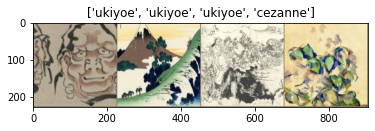

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def test(model, testloader, criterion, dataset_type):
    running_loss = 0
    running_corrects = 0
    for inputs, labels in testloader:
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        test_loss = running_loss / dataset_sizes[dataset_type]
        test_acc = running_corrects.double() / dataset_sizes[dataset_type]
    print("test loss is "+str(test_loss))
    print("test accuracy is "+str(test_acc.cpu().numpy()))

    # return test_loss, test_acc

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## ResNet-18

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8994 Acc: 0.6717
val Loss: 0.3235 Acc: 0.8997

Epoch 1/24
----------
train Loss: 0.8041 Acc: 0.7279
val Loss: 0.4043 Acc: 0.8761

Epoch 2/24
----------
train Loss: 0.6699 Acc: 0.7735
val Loss: 0.1771 Acc: 0.9558

Epoch 3/24
----------
train Loss: 0.6154 Acc: 0.7919
val Loss: 0.5120 Acc: 0.7994

Epoch 4/24
----------
train Loss: 0.5837 Acc: 0.7989
val Loss: 0.2574 Acc: 0.9174

Epoch 5/24
----------
train Loss: 0.4733 Acc: 0.8371
val Loss: 0.3591 Acc: 0.8702

Epoch 6/24
----------
train Loss: 0.5292 Acc: 0.8290
val Loss: 0.1742 Acc: 0.9440

Epoch 7/24
----------
train Loss: 0.3371 Acc: 0.8912
val Loss: 0.1401 Acc: 0.9351

Epoch 8/24
----------
train Loss: 0.3487 Acc: 0.8930
val Loss: 0.1543 Acc: 0.9351

Epoch 9/24
----------
train Loss: 0.3003 Acc: 0.8960
val Loss: 0.1668 Acc: 0.9263

Epoch 10/24
----------
train Loss: 0.2810 Acc: 0.9136
val Loss: 0.1240 Acc: 0.9558

Epoch 11/24
----------
train Loss: 0.3036 Acc: 0.9000
val Loss: 0.1285 Acc: 0.9528

Ep

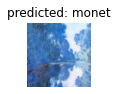

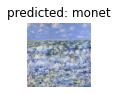

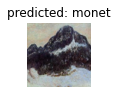

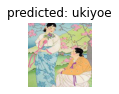

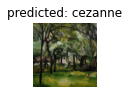

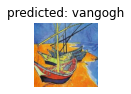

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5253 Acc: 0.8066
val Loss: 0.3148 Acc: 0.8938

Epoch 1/24
----------
train Loss: 0.5215 Acc: 0.8074
val Loss: 0.3553 Acc: 0.8850

Epoch 2/24
----------
train Loss: 0.5244 Acc: 0.8107
val Loss: 0.3063 Acc: 0.8968

Epoch 3/24
----------
train Loss: 0.5364 Acc: 0.7993
val Loss: 0.3944 Acc: 0.8732

Epoch 4/24
----------
train Loss: 0.4852 Acc: 0.8147
val Loss: 0.3119 Acc: 0.9056

Epoch 5/24
----------
train Loss: 0.5342 Acc: 0.7930
val Loss: 0.3479 Acc: 0.8938

Epoch 6/24
----------
train Loss: 0.5239 Acc: 0.7989
val Loss: 0.3245 Acc: 0.8820

Epoch 7/24
----------
train Loss: 0.5217 Acc: 0.8015
val Loss: 0.3435 Acc: 0.8909

Epoch 8/24
----------
train Loss: 0.5536 Acc: 0.7901
val Loss: 0.3703 Acc: 0.8673

Epoch 9/24
----------
train Loss: 0.5095 Acc: 0.8125
val Loss: 0.3055 Acc: 0.8997

Epoch 10/24
----------
train Loss: 0.5124 Acc: 0.8092
val Loss: 0.3457 Acc: 0.8909

Epoch 11/24
----------
train Loss: 0.5276 Acc: 0.7985
val Loss: 0.3206 Acc: 0.8997

Ep

## ResNet-152

In [ ]:
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8290 Acc: 0.6967
val Loss: 0.2981 Acc: 0.8850

Epoch 1/24
----------
train Loss: 0.6466 Acc: 0.7658
val Loss: 0.3369 Acc: 0.8643

Epoch 2/24
----------
train Loss: 0.5358 Acc: 0.8048
val Loss: 1.4766 Acc: 0.8761

Epoch 3/24
----------
train Loss: 0.5268 Acc: 0.8103
val Loss: 0.2191 Acc: 0.9292

Epoch 4/24
----------
train Loss: 0.4384 Acc: 0.8430
val Loss: 0.3032 Acc: 0.9086

Epoch 5/24
----------
train Loss: 0.3893 Acc: 0.8621
val Loss: 0.3610 Acc: 0.8555

Epoch 6/24
----------
train Loss: 0.3463 Acc: 0.8816
val Loss: 0.6333 Acc: 0.8850

Epoch 7/24
----------
train Loss: 0.2641 Acc: 0.9154
val Loss: 0.1410 Acc: 0.9617

Epoch 8/24
----------
train Loss: 0.1955 Acc: 0.9368
val Loss: 0.1306 Acc: 0.9617

Epoch 9/24
----------
train Loss: 0.1961 Acc: 0.9393
val Loss: 0.1538 Acc: 0.9440

Epoch 10/24
----------
train Loss: 0.1634 Acc: 0.9408
val Loss: 0.2032 Acc: 0.9292

Epoch 11/24
----------
train Loss: 0.1789 Acc: 0.9401
val Loss: 0.1662 Acc: 0.9440

Ep

In [ ]:
model_conv = torchvision.models.resnet152(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8666 Acc: 0.6614
val Loss: 0.3538 Acc: 0.8761

Epoch 1/24
----------
train Loss: 0.6972 Acc: 0.7423
val Loss: 0.5394 Acc: 0.8437

Epoch 2/24
----------
train Loss: 0.6592 Acc: 0.7574
val Loss: 0.3561 Acc: 0.8584

Epoch 3/24
----------
train Loss: 0.6145 Acc: 0.7776
val Loss: 0.3414 Acc: 0.8791

Epoch 4/24
----------
train Loss: 0.6109 Acc: 0.7768
val Loss: 0.3069 Acc: 0.8997

Epoch 5/24
----------
train Loss: 0.5570 Acc: 0.8033
val Loss: 0.2772 Acc: 0.8997

Epoch 6/24
----------
train Loss: 0.5731 Acc: 0.7960
val Loss: 0.4497 Acc: 0.8850

Epoch 7/24
----------
train Loss: 0.4676 Acc: 0.8290
val Loss: 0.3748 Acc: 0.8820

Epoch 8/24
----------
train Loss: 0.4673 Acc: 0.8312
val Loss: 0.3071 Acc: 0.9027

Epoch 9/24
----------
train Loss: 0.4767 Acc: 0.8257
val Loss: 0.3296 Acc: 0.8791

Epoch 10/24
----------
train Loss: 0.4642 Acc: 0.8254
val Loss: 0.3598 Acc: 0.8732

Epoch 11/24
----------
train Loss: 0.4756 Acc: 0.8243
val Loss: 0.3377 Acc: 0.9056

Ep

## ResNeXt-101-32x8d

In [ ]:
model_ft = models.resnext101_32x8d(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.7720 Acc: 0.7140
val Loss: 0.2806 Acc: 0.8997

Epoch 1/14
----------
train Loss: 0.4531 Acc: 0.8412
val Loss: 0.2320 Acc: 0.9292

Epoch 2/14
----------
train Loss: 0.3676 Acc: 0.8706
val Loss: 0.1474 Acc: 0.9558

Epoch 3/14
----------
train Loss: 0.2913 Acc: 0.9011
val Loss: 0.1619 Acc: 0.9469

Epoch 4/14
----------
train Loss: 0.2717 Acc: 0.9103
val Loss: 0.1466 Acc: 0.9528

Epoch 5/14
----------
train Loss: 0.2515 Acc: 0.9180
val Loss: 0.0964 Acc: 0.9764

Epoch 6/14
----------
train Loss: 0.2211 Acc: 0.9202
val Loss: 0.0857 Acc: 0.9735

Epoch 7/14
----------
train Loss: 0.2031 Acc: 0.9335
val Loss: 0.1040 Acc: 0.9735

Epoch 8/14
----------
train Loss: 0.1850 Acc: 0.9408
val Loss: 0.1072 Acc: 0.9794

Epoch 9/14
----------
train Loss: 0.1657 Acc: 0.9478
val Loss: 0.1203 Acc: 0.9735

Epoch 10/14
----------
train Loss: 0.1854 Acc: 0.9397
val Loss: 0.0751 Acc: 0.9764

Epoch 11/14
----------
train Loss: 0.1727 Acc: 0.9460
val Loss: 0.0799 Acc: 0.9823

Ep

In [ ]:
model_conv = torchvision.models.resnext101_32x8d(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 0.8082 Acc: 0.6846
val Loss: 0.3846 Acc: 0.8791

Epoch 1/14
----------
train Loss: 0.5945 Acc: 0.7643
val Loss: 0.3230 Acc: 0.8909

Epoch 2/14
----------
train Loss: 0.5690 Acc: 0.7860
val Loss: 0.3040 Acc: 0.9115

Epoch 3/14
----------
train Loss: 0.5373 Acc: 0.7949
val Loss: 0.3634 Acc: 0.8850

Epoch 4/14
----------
train Loss: 0.5400 Acc: 0.7971
val Loss: 0.2860 Acc: 0.9145

Epoch 5/14
----------
train Loss: 0.5019 Acc: 0.8158
val Loss: 0.3020 Acc: 0.9145

Epoch 6/14
----------
train Loss: 0.4876 Acc: 0.8173
val Loss: 0.3738 Acc: 0.8909

Epoch 7/14
----------
train Loss: 0.4570 Acc: 0.8316
val Loss: 0.3182 Acc: 0.8820

Epoch 8/14
----------
train Loss: 0.4562 Acc: 0.8294
val Loss: 0.2678 Acc: 0.9086

Epoch 9/14
----------
train Loss: 0.4577 Acc: 0.8312
val Loss: 0.2879 Acc: 0.9145

Epoch 10/14
----------
train Loss: 0.4350 Acc: 0.8386
val Loss: 0.2736 Acc: 0.9115

Epoch 11/14
----------
train Loss: 0.4357 Acc: 0.8368
val Loss: 0.2438 Acc: 0.9204

Ep

In [ ]:
test(model_ft, dataloaders['stargan_v2'], criterion, "stargan_v2")

test loss is 0.6927598414950062
test accuracy is 0.6782956058588548


In [ ]:
test(model_ft, dataloaders['stargan_v1'], criterion, "stargan_v1")

test loss is 1.534257563723772
test accuracy is 0.5452002098268928


In [ ]:
# test accuracy trained on resnext101_32x8d
criterion = nn.CrossEntropyLoss()
test(model_ft, dataloaders['test'], criterion, "test")
test(model_ft, dataloaders['cyclegan_test'], criterion, "cyclegan_test")
test(model_ft, dataloaders['stargan_v1'], criterion, "stargan_v1")
test(model_ft, dataloaders['stargan_v2'], criterion, "stargan_v2")
#test(model_conv, dataloaders['test'])

## Summary

1.  ResNet-18: val 0.968;
2.  ResNet-152: val 0.974;
3.  ResNeXt-101-32x8d: val 0.988; test 0.985

